<a href="https://colab.research.google.com/github/shoubhikchakraborty/mask_detection/blob/main/mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uploading the kaggle.json file
from google.colab import files
files.upload()

In [ ]:
# placing kaggle.json in kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# updating the kaggle server version
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Uninstalling kaggle-1.5.8:
  Successfully uninstalled kaggle-1.5.8
     |████████████████████████████████| 1.5MB 5.4MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=ed5ba9e03ba57f133d81743cb2a2db6a2c5630fe1ab5c8673a5bae8d346db465
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle


In [ ]:
! kaggle datasets download -d wobotintelligence/face-mask-detection-dataset

100% 2.50G/2.50G [00:34<00:00, 89.2MB/s]
100% 2.50G/2.50G [00:34<00:00, 77.5MB/s]


In [ ]:
! kaggle datasets download -d andrewmvd/face-mask-detection

 99% 393M/398M [00:05<00:00, 95.2MB/s]
100% 398M/398M [00:05<00:00, 79.5MB/s]


In [ ]:
# unzipping the data
import zipfile
zip_ref = zipfile.ZipFile("/content/face-mask-detection-dataset.zip", 'r')
zip_ref.extractall("/content/face-mask-detection-dataset")
zip_ref.close()

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/face-mask-detection.zip", 'r')
zip_ref.extractall("/content/face-mask-detection")
zip_ref.close()

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1

!gcc --version
# opencv is pre-installed on colab

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6 MB 6.1 MB/s 
     |████████████████████████████████| 2.2 MB 10.1 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20200926-py3-none-any.whl size=43980 sha256=05ac2e9a276eda054734f1ffd1faab143439e20c0dbe76715720188acff14de2
  Stored in directory: /root/.cache/pip/wheels/7f/85/2a/2919a5db80e3edc5aaff7f4e82edb8b99ccde1aa731f46060f
Successfully built fvcore
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

albumentations 0.1.12 requires imgaug<0.2.7,>=0.2

In [ ]:
!nvidia-smi

Mon Sep 28 13:55:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from pprint import pprint
import pandas as pd
import cv2
import numpy as np

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import torch, torchvision
import os, json, cv2, random, shutil, glob
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [ ]:
train = pd.read_csv('/content/face-mask-detection-dataset/train.csv')

In [ ]:
train.head()

name   x1   x2   y1   y2       classname
0  2756.png   69  126  294  392  face_with_mask
1  2756.png  505   10  723  283  face_with_mask
2  2756.png   75  252  264  390   mask_colorful
3  2756.png  521  136  711  277   mask_colorful
4  6098.jpg  360   85  728  653    face_no_mask

In [ ]:
train.shape

(15412, 6)

In [ ]:
train.rename(columns = {'x2': 'y1', 'y1': 'x2'}, inplace = True)

In [ ]:
train['classname'].unique()

array(['face_with_mask', 'mask_colorful', 'face_no_mask',
       'face_with_mask_incorrect', 'mask_surgical', 'face_other_covering',
       'scarf_bandana', 'eyeglasses', 'helmet', 'face_shield',
       'sunglasses', 'hood', 'hat', 'goggles', 'hair_net', 'hijab_niqab',
       'other', 'gas_mask', 'balaclava_ski_mask', 'turban'], dtype=object)

In [ ]:
train['classname'].value_counts()

face_with_mask              4180
mask_surgical               2430
mask_colorful               1876
face_no_mask                1569
face_other_covering         1372
eyeglasses                   914
hat                          823
sunglasses                   358
hair_net                     287
scarf_bandana                260
goggles                      192
helmet                       187
hijab_niqab                  173
face_shield                  160
hood                         159
face_with_mask_incorrect     150
balaclava_ski_mask           134
turban                        94
gas_mask                      55
other                         39
Name: classname, dtype: int64

In [ ]:
train.drop(train.index[train['classname'] == 'face_with_mask'], inplace = True)
train.drop(train.index[train['classname'] == 'face_other_covering'], inplace = True)

In [ ]:
train.drop(train.index[train['classname'] == 'eyeglasses'], inplace = True)
train.drop(train.index[train['classname'] == 'hat'], inplace = True)
train.drop(train.index[train['classname'] == 'sunglasses'], inplace = True)
train.drop(train.index[train['classname'] == 'hair_net'], inplace = True)
train.drop(train.index[train['classname'] == 'helmet'], inplace = True)
train.drop(train.index[train['classname'] == 'hijab_niqab'], inplace = True)
train.drop(train.index[train['classname'] == 'hood'], inplace = True)
train.drop(train.index[train['classname'] == 'turban'], inplace = True)
train.drop(train.index[train['classname'] == 'goggles'], inplace = True)

In [ ]:
train['classname'].value_counts()

mask_surgical               2430
mask_colorful               1876
face_no_mask                1569
scarf_bandana                260
face_shield                  160
face_with_mask_incorrect     150
balaclava_ski_mask           134
gas_mask                      55
other                         39
Name: classname, dtype: int64

In [ ]:
train.pivot_table(index= 'classname', aggfunc=len)

name    x1    x2    y1    y2
classname                                             
balaclava_ski_mask         134   134   134   134   134
face_no_mask              1569  1569  1569  1569  1569
face_shield                160   160   160   160   160
face_with_mask_incorrect   150   150   150   150   150
gas_mask                    55    55    55    55    55
mask_colorful             1876  1876  1876  1876  1876
mask_surgical             2430  2430  2430  2430  2430
other                       39    39    39    39    39
scarf_bandana              260   260   260   260   260

In [ ]:
train.shape

(6673, 6)

In [ ]:
def annotate_image(annotations, resize=True):
  name = annotations.name.to_numpy()[0]
  img = cv2.cvtColor(cv2.imread(f'/content/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/{name}'), cv2.COLOR_BGR2RGB)

  for i, a in annotations.iterrows():    
    cv2.rectangle(img, (a.x1, a.y1), (a.x2, a.y2), (255, 0, 0), 8)
  if not resize:
    return img

  return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

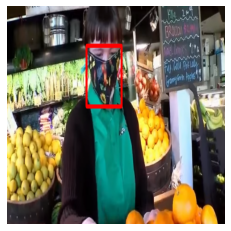

In [ ]:
import matplotlib.pyplot as plt
img_df = train[train.name == train.name.unique()[20]]
img = annotate_image(img_df, resize=True)

plt.imshow(img)
plt.axis('off');

In [ ]:
train.head()

name   x1   y1   x2   y2                 classname
2  2756.png   75  252  264  390             mask_colorful
3  2756.png  521  136  711  277             mask_colorful
4  6098.jpg  360   85  728  653              face_no_mask
5  6427.png  218   98  577  580  face_with_mask_incorrect
6  6427.png  278  386  582  582             mask_surgical

In [ ]:
unique_files = train.name.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.80), replace=False))
train_df = train[train.name.isin(train_files)]
test_df = train[~train.name.isin(train_files)]

In [ ]:
train_df.shape, test_df.shape

((5319, 6), (1354, 6))

In [ ]:
def get_dict(df, categories, img_dir):
  dataset_dicts = []
  for idx, image in enumerate(df.name.unique()):
    record = {}

    image_df = df[df.name == image]

    filename = img_dir+"/"+image
    height, width = cv2.imread(filename).shape[:2]
    record["file_name"] = filename
    record["height"] = height
    record["width"] = width
    record["image_id"] = idx

    objs = []
    for _, row in image_df.iterrows():
      
      x1 = int(row.x1)
      y1 = int(row.y1)
      x2 = int(row.x2)
      y2 = int(row.y2)

      obj = {
        "bbox": [x1, y1, x2, y2],
        "bbox_mode": BoxMode.XYXY_ABS,
        "category_id": categories.index(row.classname)
      }

      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
classes = train.classname.unique().tolist()

In [ ]:
classes

['mask_colorful',
 'face_no_mask',
 'face_with_mask_incorrect',
 'mask_surgical',
 'scarf_bandana',
 'face_shield',
 'other',
 'gas_mask',
 'balaclava_ski_mask']

In [ ]:
for d in ["train", "val"]:
  DatasetCatalog.register("masks_" + d, lambda d=d: get_dict(train_df if d == "train" else test_df, classes,"/content/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images" ))
  MetadataCatalog.get("masks_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("masks_train")

In [ ]:
DatasetCatalog.get("masks_train")

[{'annotations': [{'bbox': [75, 252, 264, 390],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox': [521, 136, 711, 277],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}],
  'file_name': '/content/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/2756.png',
  'height': 566,
  'image_id': 0,
  'width': 725},
 {'annotations': [{'bbox': [360, 85, 728, 653],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1}],
  'file_name': '/content/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/6098.jpg',
  'height': 989,
  'image_id': 1,
  'width': 1484},
 {'annotations': [{'bbox': [218, 98, 577, 580],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 2},
   {'bbox': [278, 386, 582, 582],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 3}],
  'file_name': '/content/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/6427.png',
  'height': 741,
  'image_id': 2,
  '

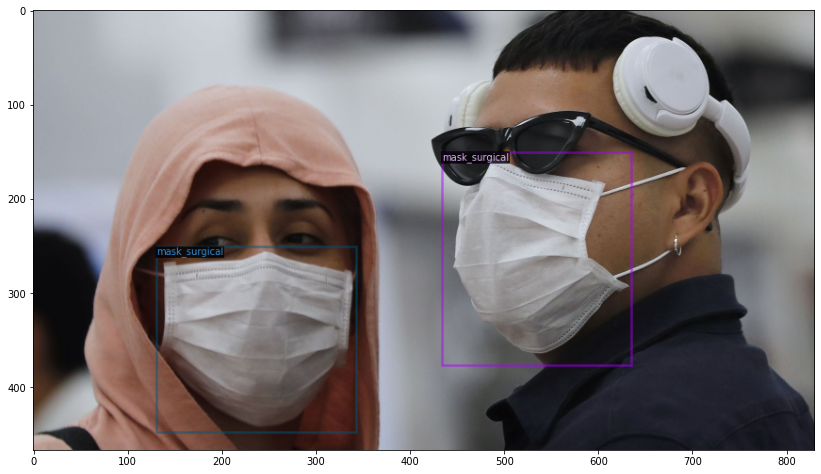

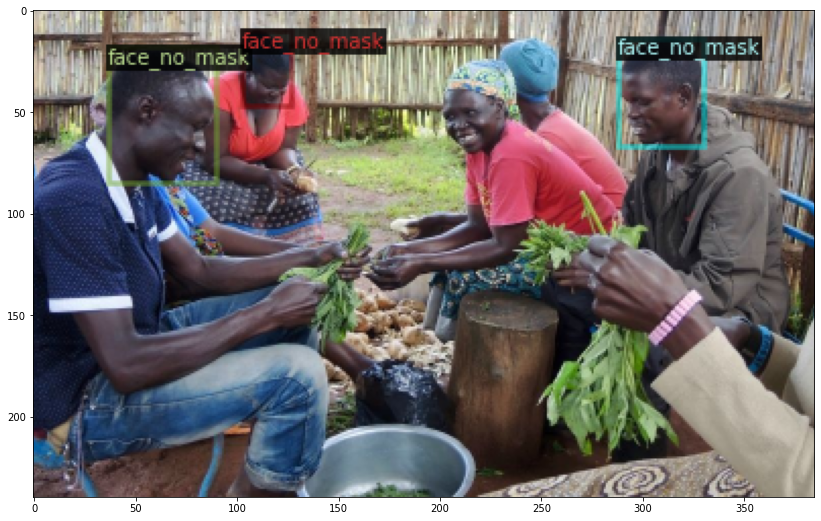

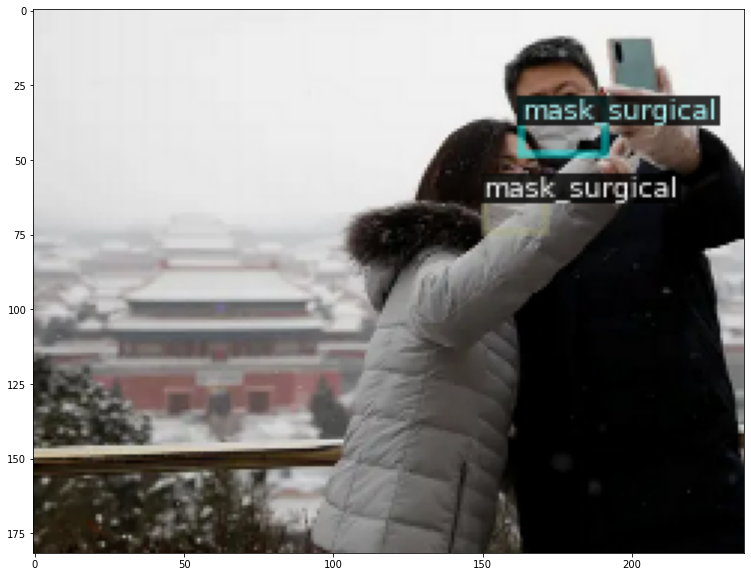

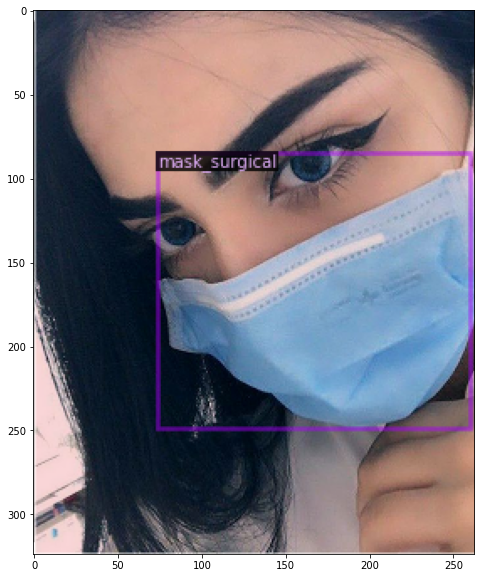

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('masks_train')
for d in random.sample(dataset_dicts,4):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=statement_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
)

In [ ]:
cfg.DATASETS.TRAIN = ("masks_train",)
cfg.DATASETS.TEST = ("masks_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.OUTPUT_DIR = '/content/drive/My Drive/detectron2/mask_detection'

In [ ]:
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

In [ ]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

cfg.TEST.EVAL_PERIOD = 500

In [ ]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

  @classmethod
  def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)


In [ ]:
trainer = CocoTrainer(cfg) 

[09/28 14:10:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
train_data_loader = trainer.build_train_loader(cfg)
data_iter = iter(train_data_loader)
batch = next(data_iter)

[09/28 14:12:36 d2.data.build]: Removed 0 images with no usable annotations. 3096 images left.
[09/28 14:12:37 d2.data.common]: Serializing 3096 elements to byte tensors and concatenating them all ...
[09/28 14:12:37 d2.data.common]: Serialized dataset takes 0.88 MiB
[09/28 14:12:37 d2.data.build]: Using training sampler TrainingSampler


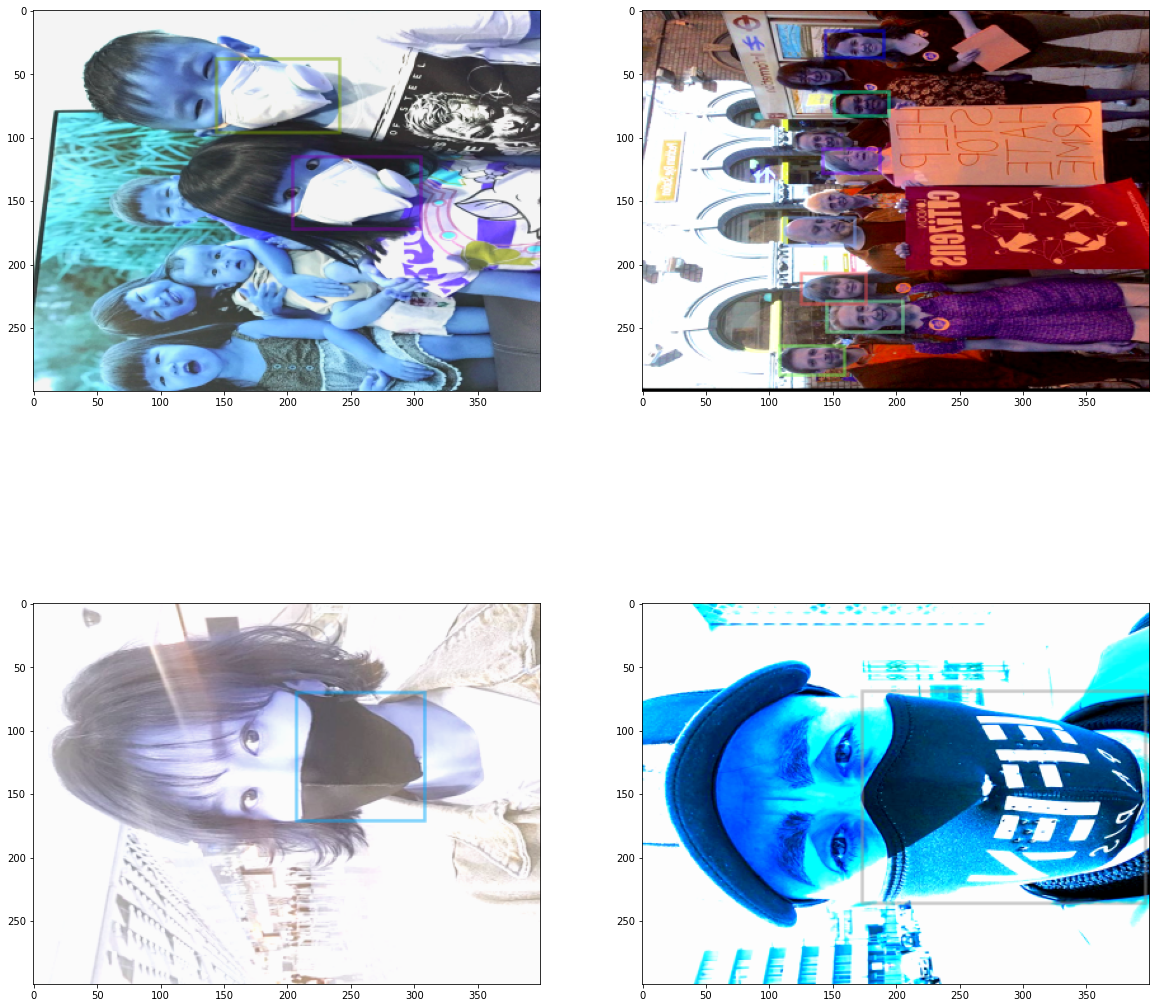

In [ ]:
rows, cols = 2, 2
plt.figure(figsize=(20,20))

for i, per_image in enumerate(batch[:4]):
    
    plt.subplot(rows, cols, i+1)
    
    # Pytorch tensor is in (C, H, W) format
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

    visualizer = Visualizer(img, metadata=statement_metadata, scale=0.5)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    plt.imshow(vis.get_image()[:, :, ::-1])

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()

model_final_68b088.pkl: 421MB [00:06, 64.7MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (10, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (10,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (36, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.


[09/28 14:17:03 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[09/28 14:17:28 d2.utils.events]:  eta: 0:29:28  iter: 19  total_loss: 2.542  loss_cls: 2.340  loss_box_reg: 0.103  loss_rpn_cls: 0.085  loss_rpn_loc: 0.015  time: 1.1857  data_time: 0.0645  lr: 0.000020  max_mem: 5784M
[09/28 14:17:52 d2.utils.events]:  eta: 0:28:57  iter: 39  total_loss: 1.983  loss_cls: 1.727  loss_box_reg: 0.118  loss_rpn_cls: 0.041  loss_rpn_loc: 0.009  time: 1.1948  data_time: 0.0356  lr: 0.000040  max_mem: 5784M
[09/28 14:18:17 d2.utils.events]:  eta: 0:28:43  iter: 59  total_loss: 0.895  loss_cls: 0.680  loss_box_reg: 0.140  loss_rpn_cls: 0.060  loss_rpn_loc: 0.010  time: 1.2063  data_time: 0.0598  lr: 0.000060  max_mem: 5784M
[09/28 14:18:41 d2.utils.events]:  eta: 0:28:27  iter: 79  total_loss: 0.420  loss_cls: 0.224  loss_box_reg: 0.100  loss_rpn_cls: 0.085  loss_rpn_loc: 0.010  time: 1.2068  data_time: 0.0323  lr: 0.000080  max_mem: 5784M
[09/28 14:19:05 d2.utils.events]:  eta: 0:28:01  iter: 99  total_loss: 0.446  loss_cls: 0.239  loss_box_reg: 0.149  loss

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

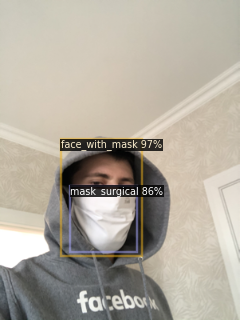

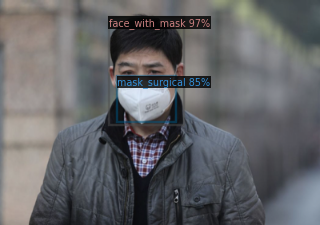

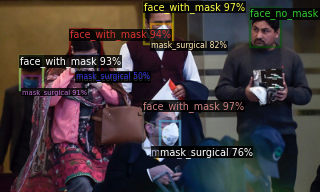

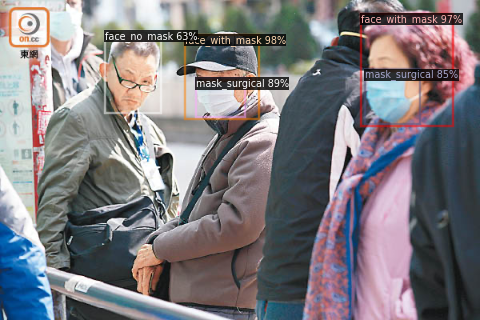

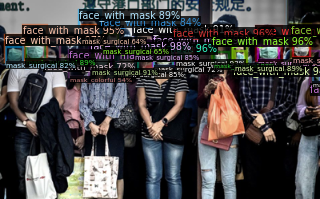

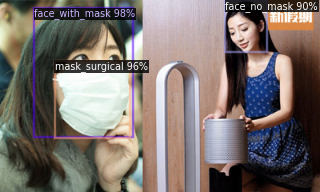

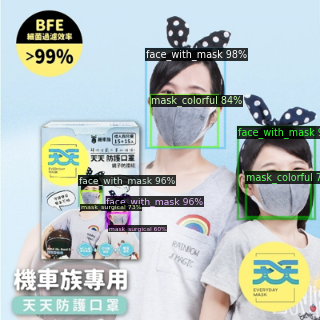

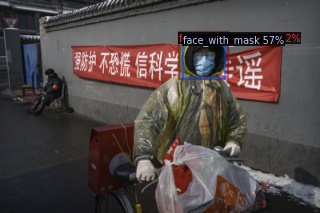

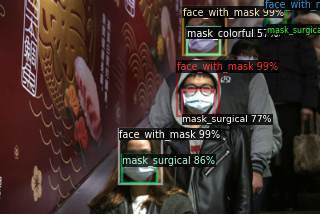

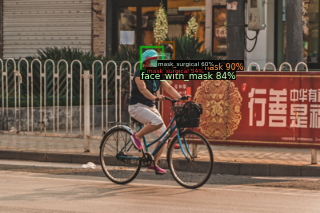

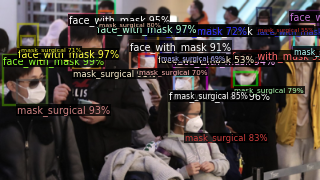

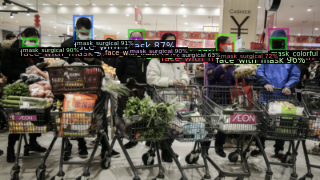

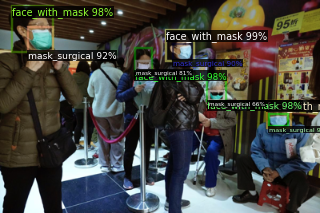

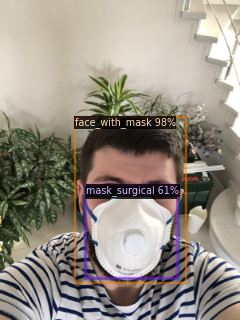

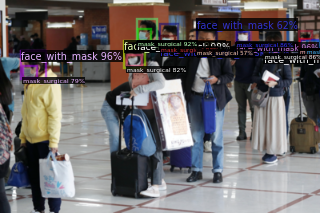

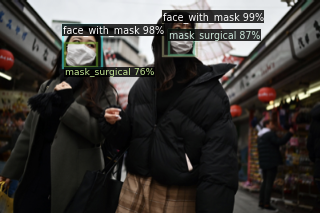

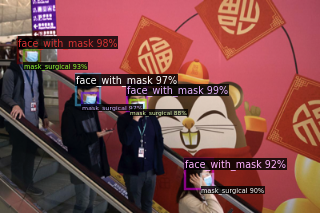

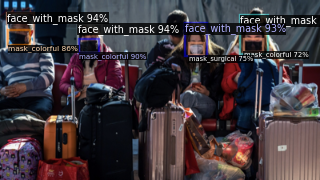

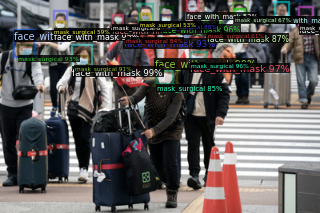

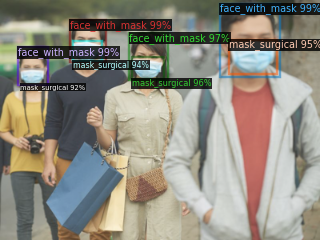

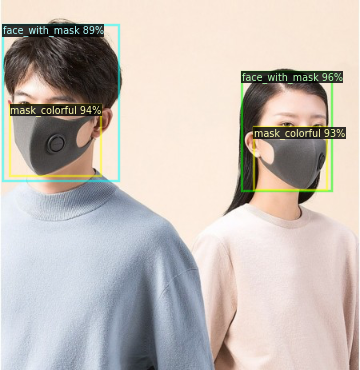

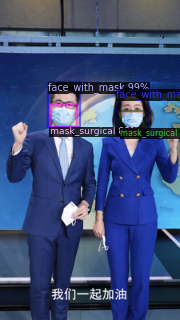

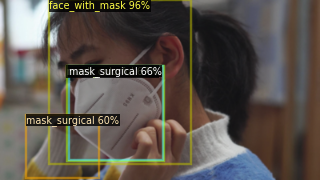

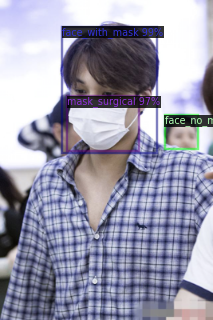

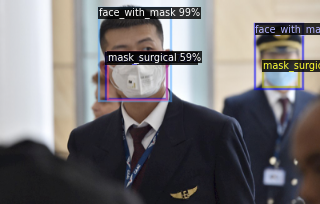

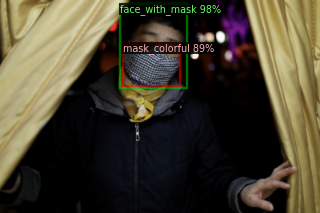

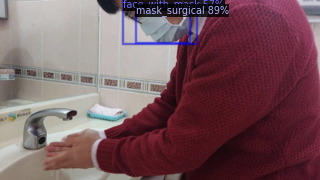

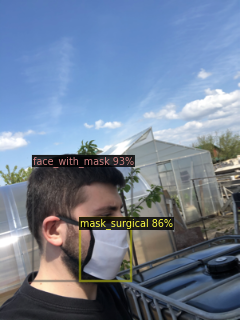

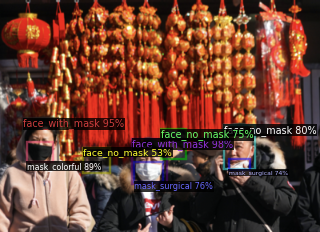

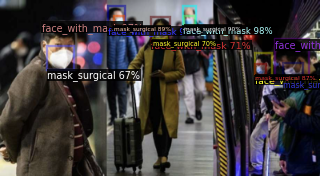

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/face-mask-detection/images/**.png'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=statement_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])